In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import logging
import math
import os
import re
from pathlib import Path
from typing import List, Dict
from dataclasses import asdict

import rich
import rich.logging

# Set up logging
console = rich.console.Console(
    force_jupyter=False,
    # stderr=True,
    theme=rich.theme.Theme({
        "logging.level.debug": "cyan",
        "logging.level.info": "green"
    }
))

logging.getLogger().setLevel(logging.INFO)

log = logging.getLogger('liposome-segment')
log.setLevel(logging.INFO)
log.handlers.clear()
log.addHandler(rich.logging.RichHandler(console=console, enable_link_path=False))
log.info("Logging initialized")

[12/15/25 23:11:21] INFO     Logging initialized                3693060253.py:33


In [2]:
data = pd.read_csv("./20251119-nucleus-liposome-analysis-data.csv")

In [3]:
data["well"] = data["well"].str.replace("/", "")

In [4]:
platemap = pd.read_csv("./20251119-nucleus-liposome-platemap.csv", index_col=0)

In [5]:
data = data.merge(platemap, left_on="well", right_on="Well")

In [6]:
data = data[data["Experiment Name"] == "20251119-nucleus-liposome"]

In [7]:
data.head()

,Unnamed: 0,label,area,area_bbox,equivalent_diameter_area,feret_diameter_max,axis_major_length,axis_minor_length,perimeter,intensity_mean-0,...,SMix Vol (uL),tRNA Vol (uL),DNA Vol (uL),PPK Vol (uL),polyP Vol (uL),Mg-Ace Vol (uL),Optiprep Vol (uL),RNase Inhib Vol (uL),Water vol (uL),Rxn Volume (uL)
0,0,1,76.0,99.0,9.836982,12.083046,11.372142,8.779928,31.556349,1486.986842,...,10,4,0.95,NaN,NaN,1.6,1.33,0,10.12,40
1,1,2,66.0,90.0,9.166996,15.033296,14.717497,6.078266,33.142136,1250.272727,...,10,4,0.95,NaN,NaN,1.6,1.33,0,10.12,40
2,2,3,93.0,120.0,10.881695,15.132746,14.719081,8.293876,36.142136,1742.322581,...,10,4,0.95,NaN,NaN,1.6,1.33,0,10.12,40
3,3,4,204.0,260.0,16.116478,20.615528,20.240099,13.346665,54.627417,1309.647059,...,10,4,0.95,NaN,NaN,1.6,1.33,0,10.12,40
4,4,5,129.0,154.0,12.815924,14.866069,14.339902,11.529926,39.556349,1310.441860,...,10,4,0.95,NaN,NaN,1.6,1.33,0,10.12,40


# Basic Plots

/tmp/ipykernel_19727/3534227296.py:2: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.lineplot(


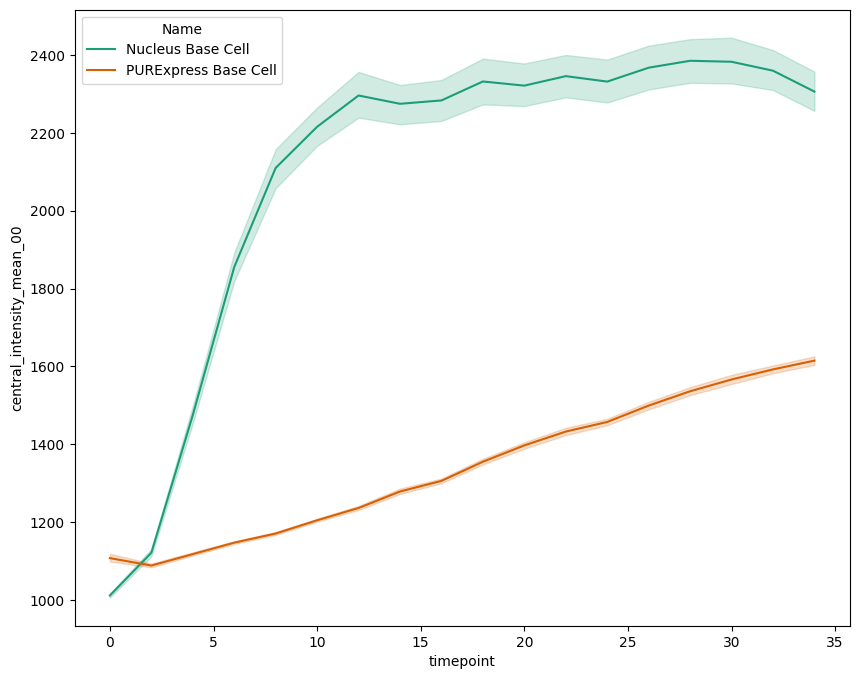

In [9]:
plt.figure(figsize=(10, 8))
ax = sns.lineplot(
    data=data,
    x="timepoint",
    y="central_intensity_mean_00",
    hue="Name",
    palette=sns.color_palette("Dark2"),
    markevery=1
    )

/tmp/ipykernel_19727/4267178261.py:6: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.lineplot(
/tmp/ipykernel_19727/4267178261.py:18: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.lineplot(
/tmp/ipykernel_19727/4267178261.py:29: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.lineplot(


Text(0.5, 1.0, 'Liposome count')

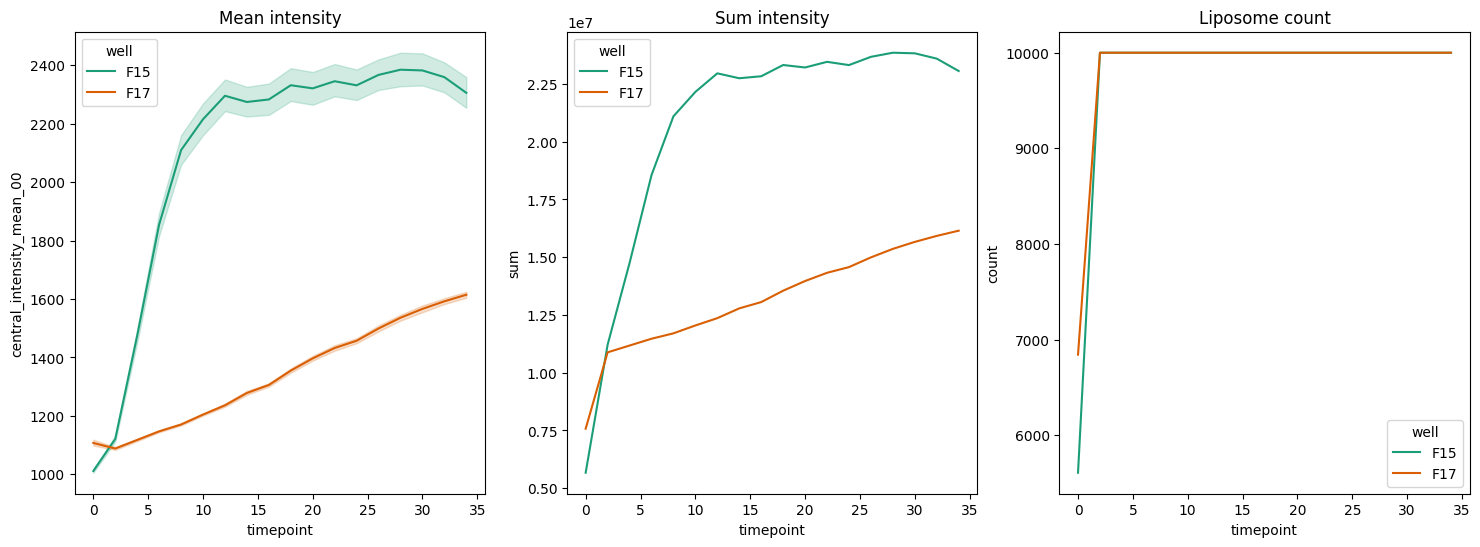

In [10]:
stats = data.groupby(["well", "timepoint"])["central_intensity_mean_00"].agg(["sum", "count", "mean"])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()

ax = sns.lineplot(
    data=data,
    x="timepoint",
    y="central_intensity_mean_00",
    hue="well",
    palette=sns.color_palette("Dark2"),
    markevery=1,
    ax=axes[0]
    )
ax.set_title("Mean intensity")


ax = sns.lineplot(
    data=stats,
    x="timepoint",
    y="sum",
    hue="well",
    palette=sns.color_palette("Dark2"),
    markevery=1,
    ax=axes[1]
    )
ax.set_title("Sum intensity")

ax = sns.lineplot(
    data=stats,
    x="timepoint",
    y="count",
    hue="well",
    palette=sns.color_palette("Dark2"),
    markevery=1,
    ax=axes[2]
    )
ax.set_title("Liposome count")

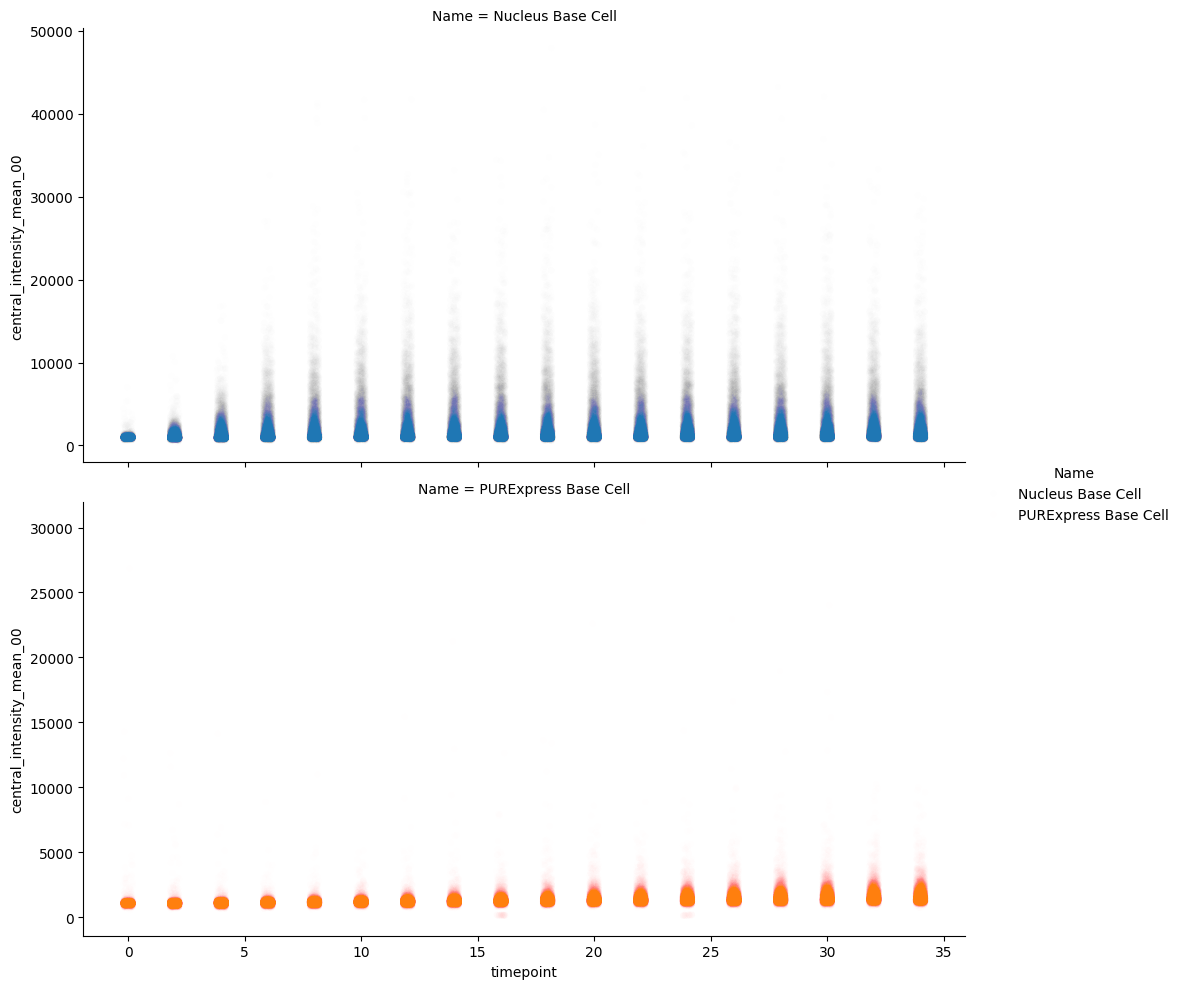

In [11]:
sns.catplot(
    data=data,
    x="timepoint",
    y="central_intensity_mean_00",
    hue="Name",
    row="Name",
    dodge=False,
    kind="strip",
    alpha=0.005,
    jitter=True,
    aspect=2,
    sharey=False,
    native_scale=True,
    # log_scale=
    )

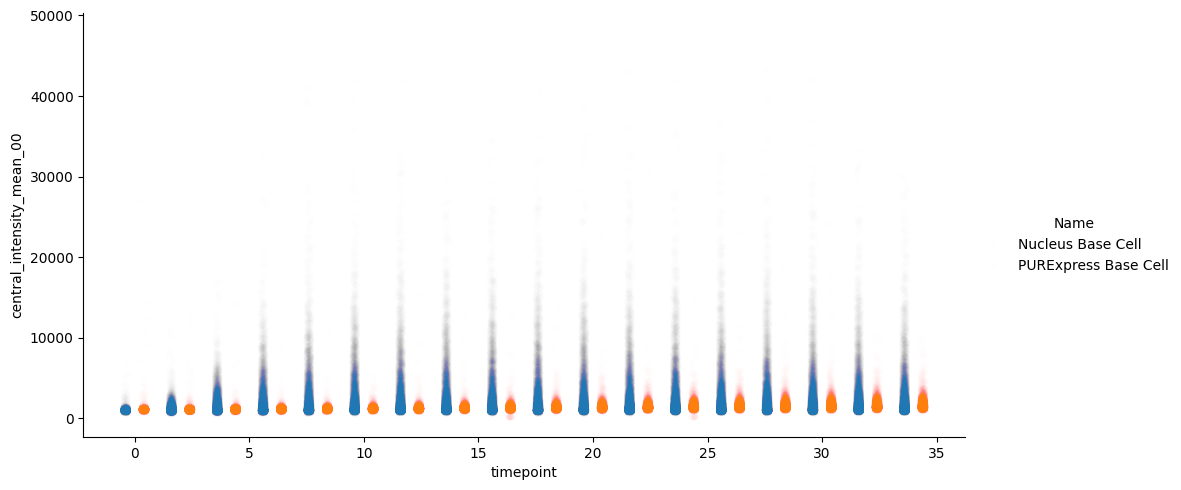

In [15]:
sns.catplot(
    data=data,
    x="timepoint",
    y="central_intensity_mean_00",
    hue="Name",
    dodge=True,
    kind="strip",
    alpha=0.005,
    jitter=True,
    aspect=2,
    sharey=False,
    native_scale=True,
    # log_scale=
    )

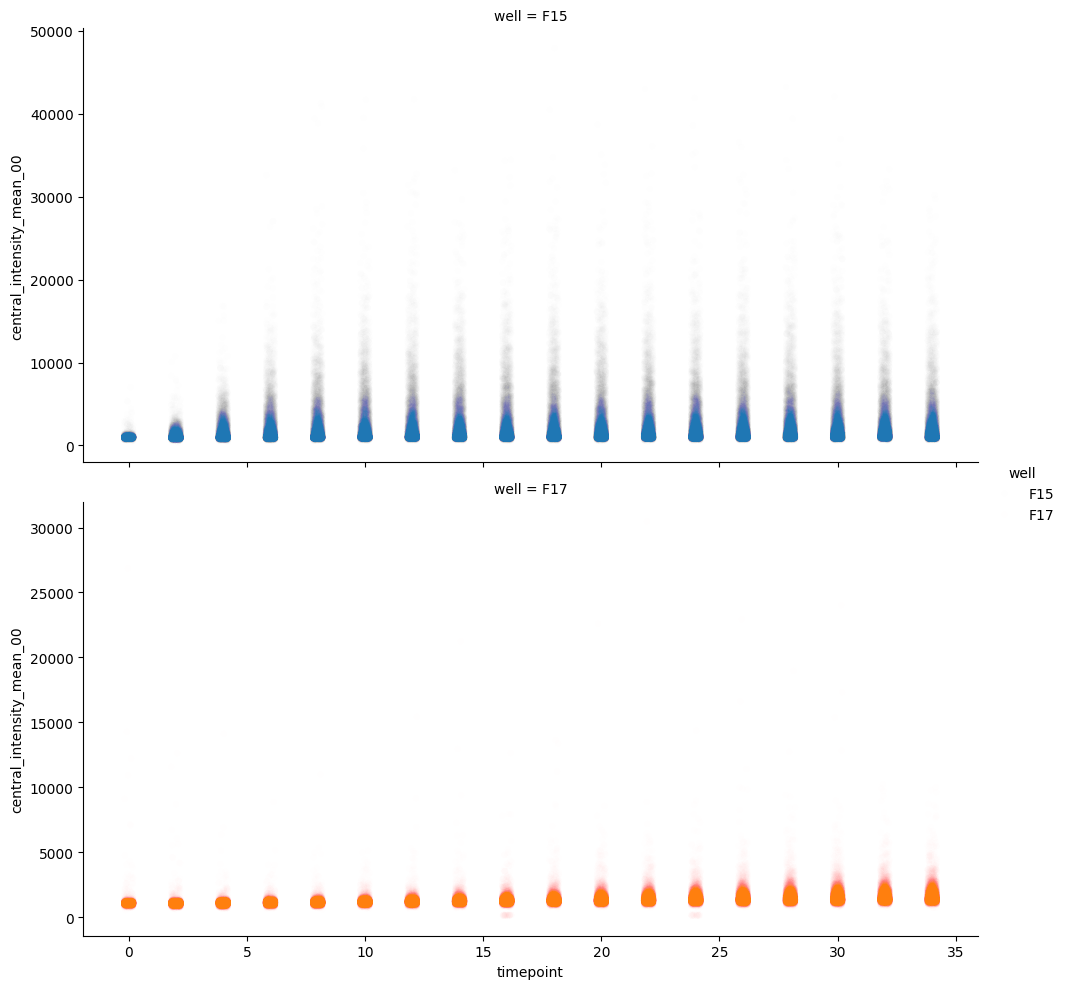

In [16]:
sns.catplot(
    data=data,
    x="timepoint",
    y="central_intensity_mean_00",
    hue="well",
    row="well",
    dodge=False,
    kind="strip",
    alpha=0.005,
    jitter=True,
    aspect=2,
    sharey=False,
    native_scale=True,
    # log_scale=
    )

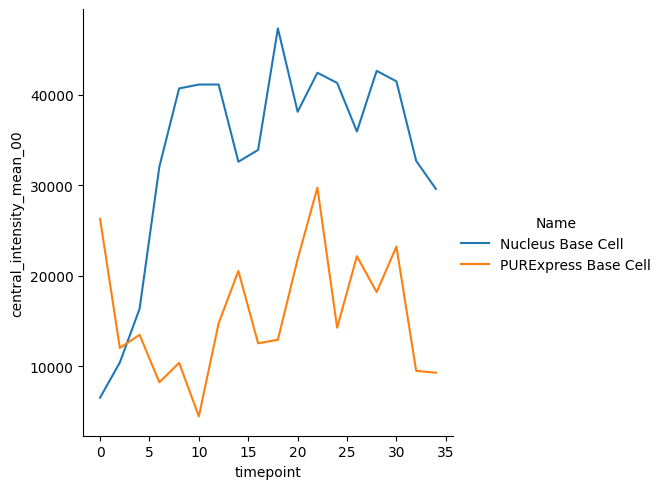

In [17]:
sns.relplot(
    data=data.groupby(["Name", "timepoint"])["central_intensity_mean_00"].agg(lambda x: x.max() - x.min()).reset_index(),
    x="timepoint",
    y="central_intensity_mean_00",
    hue="Name",
    kind="line"
)

In [22]:
d = data.set_index(["Name", "timepoint"])
d["quantile"] = data.groupby(["Name", "timepoint"])["central_intensity_mean_00"].quantile(0.95)
d = d.reset_index()

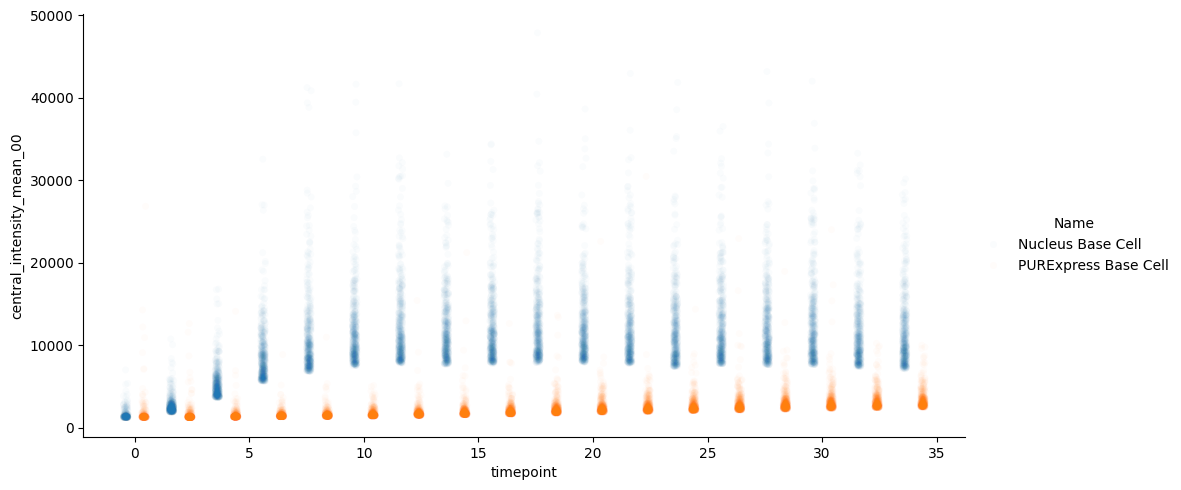

In [19]:
sns.catplot(
    data=d[d["central_intensity_mean_00"] > d["quantile"]],
    x="timepoint",
    y="central_intensity_mean_00",
    hue="Name",
    # row="well",
    dodge=True,
    kind="strip",
    alpha=0.02,
    jitter=True,
    aspect=2,
    sharey=False,
    native_scale=True,
    # log_scale=
    )

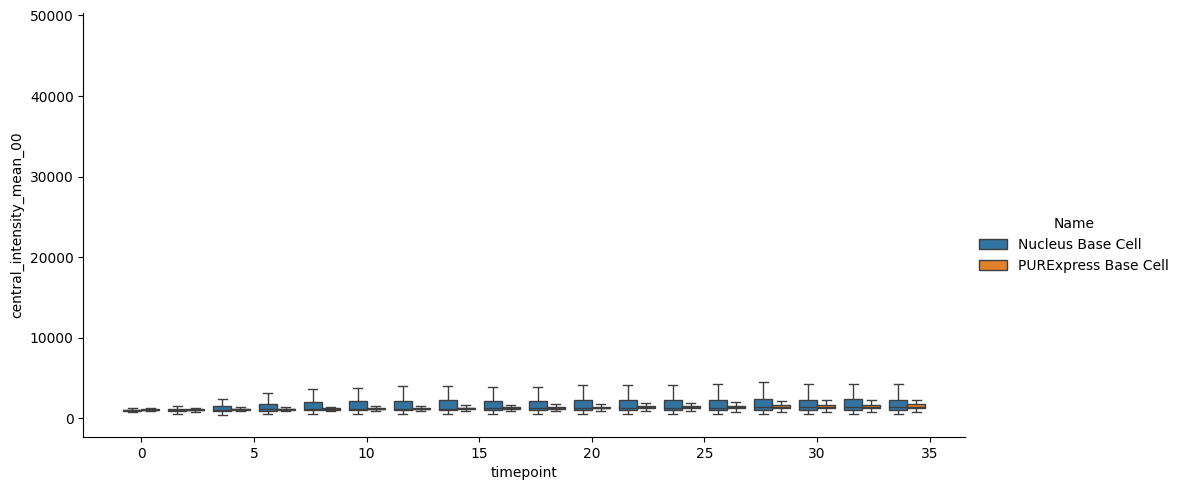

In [20]:
sns.catplot(
    data=data,
    x="timepoint",
    y="central_intensity_mean_00",
    hue="Name",
    # row="well",
    dodge=True,
    kind="box",
    aspect=2,
    sharey=False,
    native_scale=True,
    fliersize=0,
    # log_scale=
    )

<Axes: xlabel='well', ylabel='feret_diameter_max'>

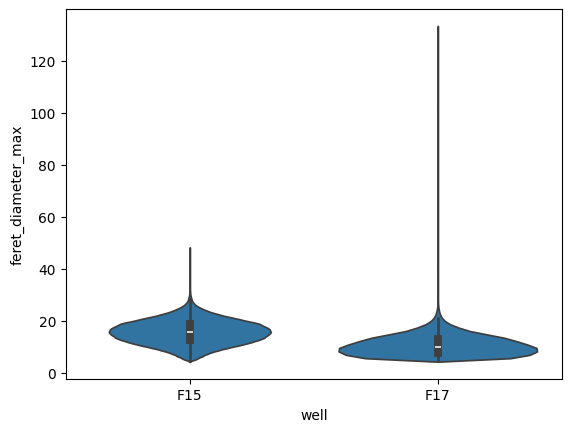

In [21]:
sns.violinplot(
    data=data,
    x="well",
    y="feret_diameter_max"
)